<a href="https://colab.research.google.com/github/kabashiy/mysite/blob/master/1_bitCSreplica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1-bit 圧縮センシングのレプリカ計算
**問題設定** \
真の信号生成モデル
$$\boldsymbol{s}^0 \sim \prod_{i=1}^N [(1-f)\delta(s_i^0) + \frac{f}{2}
\left (\delta(s^0-1) + \delta(s^0+1) \right ) ]$$
観測行列　\
$$ A_{\mu k} \sim \mathcal N(0, \rho^k/N) $$
観測過程 \
$$ b_\mu = \sum_{k=1}^N A_{\mu k} s_k^0 $$
$$ y_\mu \in \{+1,-1\}\sim P(y_\mu | b_\mu) = \Theta(y_\mu b_\mu) $$
復元過程 \
$$ \hat{\boldsymbol{s}} = \mathop{\rm argmin}_{\boldsymbol{s}} \left \{ ||\boldsymbol{s} ||_1 \right \} \quad {\rm subj. to} \quad y_\mu (b_\mu -\kappa) > 0 \quad \mu=1,2,\ldots, M $$



In [21]:
# Google drive の読み込み
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/my-modules')


Mounted at /content/drive


In [83]:
# 必要なライブラリの読み込み
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import erfc 
from numpy import sqrt, sin, cos, pi, exp
from numba import jit, f8, njit, prange
import numba_scipy

# System parameters
Nsamp = int(1.0e4)
N = 1000
alpha = 10
M = int(alpha*N)
kappa = 0.1
f = 0.1
sigS2 = 1
rho = exp(-1./M)
kMAX = N

In [38]:
# Definition of basic functions 
def H(x):
    return 0.5*erfc(x/sqrt(2))

def G(x):
    return exp(-x**2/2)/sqrt(2*pi)

def P0(y,z,T,m,q,kappa):
    arg = y*(m/sqrt(q)*z-kappa)/sqrt(T-m**2/q)
    return H(-arg)

def DP0(y,z,T,m,q,kappa):
    arg = y*(m/sqrt(q)*z-kappa)/sqrt(T-m**2/q)
    return G(arg)/sqrt(T-m**2/q)

def ReLU(x):
    return x*(x>0)

def Efunc(z,T,m,q,kappa):
    return G(z)*(P0(+1, z, T,m,q,kappa)*(-(sqrt(q)*z-kappa)>0)+P0(-1,z,T,m,q,kappa)*((sqrt(q)*z-kappa) > 0))

def Ffunc(z,T,m,q,kappa):
    return G(z)*(P0(+1,z,T,m,q,kappa)*(ReLU(-(sqrt(q)*z-kappa)))**2+P0(-1,z,T,m,q,kappa)*(ReLU(sqrt(q)*z-kappa))**2)

def Kfunc(z,T,m,q,kappa):
    return  G(z)*(DP0(+1,z,T,m,q,kappa)*ReLU(sqrt(q)*z-kappa)+DP0(-1,z,T,m,q,kappa)*ReLU(-(sqrt(q)*z-kappa)))

In [84]:
# k=1,2, ..., kMAX に関しMC積分を並列で行う
@jit('void(f8[:], f8[:], f8[:], f8[:, :], f8[:], f8[:], f8[:], f8[:], f8[:], f8, i8, i8)', nopython=True, cache=True, parallel=True)
def parallel_integrals(q_list, chi_list, m_list, Sh, E_list, F_list, K_list, S0, v, rho, kMAX, Nsamp):
    h = np.zeros((kMAX, Nsamp))
    for k in prange(kMAX):
        h[k] = K_list[k]*S0 + sqrt(F_list[k])*v
        Sh[k] = (h[k] - np.sign(h[k]))*(np.abs(h[k]) > 1)/E_list[k]

        q_list[k] = rho**k*(Sh[k]**2).mean()
        chi_list[k] = rho**k/E_list[k]*(np.abs(h[k]) > 1).mean()
        m_list[k] = rho**k*(S0*Sh[k]).mean()

In [85]:
# Initialization 
S0 = np.zeros(Nsamp)
S0[:int(f*Nsamp/2)] = np.ones(int(f*Nsamp/2))
S0[int(f*Nsamp/2):int(f*Nsamp)] = -np.ones(int(f*Nsamp/2))
Sh = np.zeros((kMAX, Nsamp))

T = (S0**2).mean()
print('T = {}'.format(T))
v = np.random.randn(Nsamp)

chi = 1
q = 0.5*sigS2
m = 0

EPS = 1.0e-6
Niter = 1000
gamma = .5

q_list = q*np.ones(kMAX)
chi_list = chi*np.ones(kMAX)
m_list = m*np.ones(kMAX) 

E_list = np.zeros(kMAX)
F_list = np.zeros(kMAX)
K_list = np.zeros(kMAX)

ERR = 100
iter = 0 
while ERR > EPS and iter < Niter:
    iter += 1
    # Recode of previous step
    kq = q
    kchi = chi
    km = m
    
    # Integrals for (chi, q, m) -> (E,F,K)
    IE, IEerr = quad(lambda z: Efunc(z, T, m, q, kappa), -10,10)
    E = alpha/chi*IE
    IF, IFerr = quad(lambda z: Ffunc(z, T, m, q, kappa), -10,10)
    F = alpha/chi**2*IF
    IK, IKerr = quad(lambda z: Kfunc(z, T, m, q, kappa),-10,10)
    K = alpha/chi*IK
    for k in range(kMAX):
        E_list[k] = rho**k*E
        F_list[k] = rho**k*F
        K_list[k] = rho**k*K

    # Integrals for (E,F,K) -> (chi, q, m)
    parallel_integrals(q_list, chi_list, m_list, Sh, E_list, F_list, K_list, S0, v, rho, kMAX, Nsamp)
    q = (1-gamma)*kq + gamma*q_list.mean()
    chi = (1-gamma)*kchi + gamma*chi_list.mean()
    m = (1-gamma)*km + gamma*m_list.mean()
        
    ERR = np.abs(kq-q) + np.abs(kchi-chi) + np.abs(km-m)

    # print("iter = {} ERR = {} E = {} F = {} K = {}".format(iter, ERR,E,F,K))
    print("iter = {} ERR = {} q = {} chi = {} m = {}".format(iter, ERR, q, chi, m))

T = 0.1
iter = 1 ERR = 0.6627466013395346 q = 0.3365155248720941 chi = 0.5575388573448635 m = 0.05680098355649215
iter = 2 ERR = 0.348817294425881 q = 0.2522386078700254 chi = 0.3224277646081881 m = 0.08623026824362906
iter = 3 ERR = 0.18858598521928022 q = 0.2051915709745431 chi = 0.1950615477752262 m = 0.10040299973446508
iter = 4 ERR = 0.10533310152116704 q = 0.1765022669597976 chi = 0.12439412806383006 m = 0.10637937752949048
iter = 5 ERR = 0.061050723080451855 q = 0.1573957963144178 chi = 0.08414614821305377 m = 0.10807565011378625
iter = 6 ERR = 0.03788745279234249 q = 0.14362260992933346 chi = 0.060507856857983815 m = 0.10759967506159807
iter = 7 ERR = 0.026502002119235486 q = 0.13304338037953234 chi = 0.046114948869211636 m = 0.10606981048093587
iter = 8 ERR = 0.019595887331909 q = 0.12453692724499343 chi = 0.0370179322787629 m = 0.10407739287401452
iter = 9 ERR = 0.015198672945565393 q = 0.11748160698920307 chi = 0.031017984733800325 m = 0.10193398772920206
iter = 10 ERR = 0.0

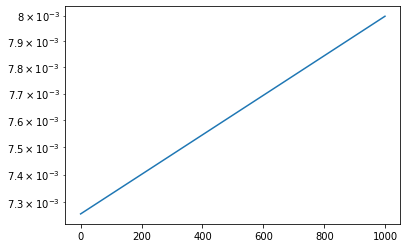

In [86]:
# plt.subplot(2,1,1)
# plt.plot(S0)
# plt.subplot(2,1,2)
plt.semilogy(((np.ones((kMAX,1))*S0.reshape((1,Nsamp))-Sh)**2).mean(axis = 1))
plt.show()